In [1]:
import sys
from pathlib import Path

import colorcet as cc
import numpy as np
import pandas as pd

# load and prepare data
import polars as pl
import seaborn as sns
import spatialdata as sd
from sainsc import LazyKDE
from tqdm import tqdm

import troutpy
from troutpy.pp import process_dataframe

/home/sergio/.local/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/sergio/.local/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/sergio/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


# Read data and perform analysis

In [2]:
sys.path.insert(0, "../../")  # this depends on the notebook depth and must be adapted per notebook
RESULTS_DIR = "/media/sergio/Meninges"
compressed_transcript_csv = Path(RESULTS_DIR, "sainsc", "trans.csv.gz")

In [3]:
xenium_path_cropped = "/media/sergio/Meninges/troutpy/rois/xenium_msbrain_5k/data_processed.zarr"
sdata = sd.read_zarr(xenium_path_cropped)

In [4]:
# parameters
binsize_param = 3
celltype_key = "leiden"
background_filter = 0.4

In [5]:
transcripts_all = sdata.points["transcripts"][
    ["gene", "x", "y", "codeword_category", "overlaps_nucleus", "transcript_id", "overlaps_cell"]
].compute()
transcripts_all = transcripts_all.reset_index(drop=True)
transcripts_all = transcripts_all.rename({"gene": "gene", "x": "x", "y": "y"})
transcripts_all = transcripts_all[transcripts_all["codeword_category"] == "predesigned_gene"]
transcripts_all = transcripts_all[transcripts_all["gene"].astype(str) != "nan"]
transcripts = transcripts_all[["gene", "x", "y", "codeword_category"]]
transcripts.columns = ["gene", "x", "y", "codeword_category"]
transcripts.to_csv(compressed_transcript_csv, compression="gzip")

In [6]:
n_threads = 16
# Read xenium file, rename columns and filter blanks/controls
transcripts = pl.read_csv(
    compressed_transcript_csv,
    columns=["gene", "x", "y"],
    schema_overrides={"gene": pl.Categorical},
    n_threads=n_threads,
)  # .filter(~pl.col("gene").cast(pl.Utf8).str.contains("(BLANK|NegControl)"))

brain = LazyKDE.from_dataframe(transcripts, resolution=1000, binsize=binsize_param, n_threads=n_threads)

# Current status --reimplemented the rust function to compute dataframe from grid.
 The issue is that we need to see the most efficent way of retrieve counts while using Sainsc

In [7]:
binsize_param = 0.2125 # this number is the um to pixel conversion

results, shape, transcript2bin_info = process_dataframe(transcripts, binsize=binsize_param, n_threads=n_threads)
# Assuming `transcript2bin_info` is a Polars DataFrame with 'bin_x' and 'bin_y' columns, we convert it to pandas df
transcript2bin_info = transcript2bin_info.to_pandas()
# This will create a new column `bin_x_y_id` as the concatenation of 'bin_x' and 'bin_y'
transcript2bin_info["bin_x_y_id"] = transcript2bin_info["bin_x"].astype(str) + "_" + transcript2bin_info["bin_y"].astype(str)


In [8]:
import numpy as np
from skimage.measure import regionprops
from skimage.measure import label

def get_label_centroid(segmentation_mask, label_id):
    """
    Get the (x, y) centroid of a region with a specific label in the segmentation mask.

    Parameters:
    - segmentation_mask: 2D array with integer labels
    - label_id: int, the target label

    Returns:
    - (x, y): centroid coordinates in image convention
    """
    props = regionprops(segmentation_mask)
    for prop in props:
        if prop.label == label_id:
            y, x = prop.centroid  # row, col → y, x
            return (x, y)
    raise ValueError(f"Label {label_id} not found in the segmentation mask.")


In [9]:
from scipy.ndimage import binary_dilation, gaussian_filter
import numpy as np
# This sort of makes sense now
import numpy as np
from scipy.ndimage import binary_dilation, gaussian_filter
from skimage.morphology import disk


# modify the 2 channel to obtain all channels useful
ch0=np.array(sdata['morphology_focus'].scale0.image.data)[0,:,:].transpose()

# extract segmentation mask
ch_segmask=np.array(sdata['cell_labels'].scale0.image.data).transpose()

#his are all genes
all_genes=list(results.keys())
# Example of 1 specific gene
image_array = np.array(results['Gad1'].todense())

## We sort of blur the expression of individual genes so that it's not only 1 pixel
# Step 1: Create a binary mask of positive points
mask = image_array > 0

# Step 2: Circular expansion (disk-shaped dilation)
# Choose radius in pixels — e.g., 3 for ~7x7 circular neighborhood
radius = 5
structuring_element = disk(radius)  # from skimage, creates a circular mask
expanded_mask = binary_dilation(mask, structure=structuring_element)

# Step 3: Convert to float and blur
expanded_float = expanded_mask.astype(float)
blurred = gaussian_filter(expanded_float, sigma=4)  # sigma controls blur softness

cell_ids=sdata['table'].obs['cell_id']
cell_id=cell_ids[0]

# this is the coordinate transformation we do
coords=sdata['table'].obsm['spatial'].copy()
coords=coords/binsize_param
minimum=np.min(coords,axis=0)

coords[:,0]=coords[:,0]-minimum[0]
coords[:,1]=coords[:,1]-minimum[1]
np.max(coords,axis=0)

for cell_id in tqdm(cell_ids[0:5]):
    cell_centroid = coords[sdata['table'].obs['cell_id'] == cell_id, :][0]
    gap=60
    cell_label=ch_segmask[int(cell_centroid[0]),int(cell_centroid[1])]
    cell_centroid_mask=get_label_centroid(ch_segmask, cell_label)
    print(cell_label)
    ylim = [cell_centroid_mask[0] - gap, cell_centroid_mask[0] + gap]
    xlim = [cell_centroid_mask[1] + gap, cell_centroid_mask[1] - gap]  # Y-axis is often inverted in image coordinates
    bin_mask=(ch_segmask==cell_label)*1
    plot_image_triplet(ch0, blurred, bin_mask, ylim, xlim)
    plt.show()


  0%|                                                                                             | 0/5 [00:00<?, ?it/s]

122


  0%|                                                                                             | 0/5 [00:02<?, ?it/s]


NameError: name 'plot_image_triplet' is not defined

# All code, implemented in function

In [10]:
#his are all genes and all cells
all_genes=list(results.keys())
cell_ids=sdata['table'].obs['cell_id']

In [11]:
import scanpy as sc
sc.pp.highly_variable_genes(sdata['table'], n_top_genes=30)

In [12]:
high_expr=sdata['table'].var.sort_values(by='means',ascending=False).head(20).index
high_variable=sdata['table'].var[sdata['table'].var['highly_variable']].index
selected_genes=np.unique(list(high_expr)+list(high_variable))

In [13]:
cell_type=sdata['table'].obs['leiden']

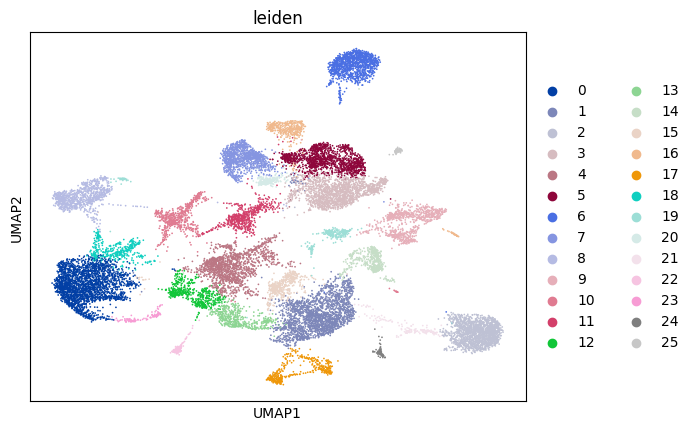

In [14]:
sc.pl.umap(sdata['table'],color='leiden')

In [30]:
cell_ids=cell_ids[10000:]#[0:5]
all_genes = [gene for gene in all_genes if gene in selected_genes]

In [31]:
import numpy as np
from scipy.ndimage import binary_dilation, gaussian_filter
from skimage.morphology import disk
from tqdm import tqdm

# Settings
crop_size = 100
gap = crop_size // 2
radius = 5
sigma = 4
structuring_element = disk(radius)

# Load images
segmask = np.array(sdata['cell_labels'].scale0.image.data).transpose()  # (H, W)
stainings = np.array(sdata['morphology_focus'].scale0.image.data).transpose(2, 1, 0)  # (H, W, C)
n_channels = stainings.shape[2]
staining_names=np.array(sdata['morphology_focus'].scale0.image.c)

n_cells = len(cell_ids)
n_genes = len(all_genes)

staining_array = np.zeros((n_cells, n_channels, crop_size, crop_size), dtype=np.float32)
gene_array = np.zeros((n_cells, n_genes, crop_size, crop_size), dtype=np.float32)
mask_array = np.zeros((n_cells, 1, crop_size, crop_size), dtype=np.float32)

# Coordinate transformation
coords = sdata['table'].obsm['spatial'].copy()
coords = coords / binsize_param
minimum = np.min(coords, axis=0)
coords[:, 0] -= minimum[0]
coords[:, 1] -= minimum[1]

# ---- PRECOMPUTE: blurred, expanded gene maps ----
precomputed_gene_maps = {}
for gene in tqdm(all_genes, desc="Precomputing gene maps"):
    gene_img = results[gene].toarray()
    expanded = binary_dilation(gene_img > 0, structure=structuring_element)
    blurred = gaussian_filter(expanded.astype(float), sigma=sigma)
    precomputed_gene_maps[gene] = blurred

# ---- MAIN LOOP ----
for i, cell_id in enumerate(tqdm(cell_ids, desc="Processing cells")):
    centroid_x, centroid_y = coords[i]
    label_id = segmask[int(centroid_x),int(centroid_y),]

    y_center, x_center = int(centroid_y), int(centroid_x)
    x_start = max(0, x_center - gap)
    x_end = x_center + gap
    y_start = max(0, y_center - gap)
    y_end = y_center + gap

    # --- Stainings ---
    for ch in range(n_channels):
        ch_img = stainings[:, :, ch]
        stain_crop = ch_img[x_start:x_end, y_start:y_end]
        staining_array[i, ch, :stain_crop.shape[0], :stain_crop.shape[1]] = stain_crop

    # --- Gene maps ---
    for j, gene in enumerate(all_genes):
        gene_map = precomputed_gene_maps[gene]
        gene_crop = gene_map[x_start:x_end, y_start:y_end]
        gene_array[i, j, :gene_crop.shape[0], :gene_crop.shape[1]] = gene_crop

    # --- Mask ---
    mask_bin = (segmask == label_id).astype(bool)
    mask_crop = mask_bin[x_start:x_end, y_start:y_end]
    mask_array[i, 0, :mask_crop.shape[0], :mask_crop.shape[1]] = mask_crop


Precomputing gene maps: 100%|███████████████████████████████████████████████████████████| 50/50 [17:18<00:00, 20.78s/it]
Processing cells: 0it [00:00, ?it/s]


In [32]:
# save all output in saving path

import os
import numpy as np

# Specify your saving path
saving_path = "/media/sergio/Meninges/campa_input/msbrain_50genes_2"  # <-- CHANGE THIS

# Create the directory if it doesn't exist
os.makedirs(saving_path, exist_ok=True)

# Save all arrays in one .npz file
output_file = os.path.join(saving_path, "campa_input_50genes_2.npz")
np.savez_compressed(
    output_file,
    staining_array=staining_array,
    gene_array=gene_array,
    mask_array=mask_array,
    cell_ids=np.array(cell_ids),
    cell_cluster=np.array(sdata['table'].obs['leiden'][10000:]),
    gene_names=np.array(all_genes),
    staining_names=staining_names # check how this is done
    
)

print(f"Output saved to: {output_file}")

Output saved to: /media/sergio/Meninges/campa_input/msbrain_50genes_2/campa_input_50genes_2.npz


In [16]:
import numpy as np
from scipy.ndimage import binary_dilation, gaussian_filter
from skimage.morphology import disk
from tqdm import tqdm

# Settings
crop_size = 100
gap = crop_size // 2
radius = 5
sigma = 4
structuring_element = disk(radius)

n_cells = len(cell_ids)
n_genes = len(all_genes)
staining_array = np.zeros((n_cells, 1, crop_size, crop_size), dtype=np.float32)
gene_array = np.zeros((n_cells, n_genes, crop_size, crop_size), dtype=np.float32)
mask_array = np.zeros((n_cells, 1, crop_size, crop_size), dtype=np.float32)

# extract segmentation mask
ch_segmask=np.array(sdata['cell_labels'].scale0.image.data).transpose()
ch0=np.array(sdata['morphology_focus'].scale0.image.data)[0,:,:].transpose()


# this is the coordinate transformation we do
coords=sdata['table'].obsm['spatial'].copy()
coords=coords/binsize_param
minimum=np.min(coords,axis=0)

coords[:,0]=coords[:,0]-minimum[0]
coords[:,1]=coords[:,1]-minimum[1]
np.max(coords,axis=0)
print(coords.shape)


# ---- PRECOMPUTE: blurred, expanded gene maps ----
precomputed_gene_maps = {}
for gene in tqdm(all_genes, desc="Precomputing gene maps"):
    gene_img = results[gene].toarray()  # faster than .todense()
    expanded = binary_dilation(gene_img > 0, structure=structuring_element)
    blurred = gaussian_filter(expanded.astype(float), sigma=sigma)
    precomputed_gene_maps[gene] = blurred

# ---- MAIN LOOP ----
for i, cell_id in enumerate(tqdm(cell_ids, desc="Processing cells")):
    centroid_x, centroid_y = coords[i]
    label_id = ch_segmask[int(centroid_x), int(centroid_y)]

    # Use coords directly instead of regionprops
    y_center, x_center = int(centroid_y), int(centroid_x)
    x_start = max(0, x_center - gap)
    x_end = x_center + gap
    y_start = max(0, y_center - gap)
    y_end = y_center + gap

    # --- Staining ---
    stain_crop = ch0[y_start:y_end, x_start:x_end]
    staining_array[i, 0, :stain_crop.shape[0], :stain_crop.shape[1]] = stain_crop

    # --- Gene maps ---
    for j, gene in enumerate(all_genes):
        gene_map = precomputed_gene_maps[gene]
        gene_crop = gene_map[y_start:y_end, x_start:x_end]
        gene_array[i, j, :gene_crop.shape[0], :gene_crop.shape[1]] = gene_crop

    # --- Mask ---
    mask_bin = (ch_segmask == label_id).astype(float)
    mask_crop = mask_bin[y_start:y_end, x_start:x_end]
    mask_array[i, 0, :mask_crop.shape[0], :mask_crop.shape[1]] = mask_crop


(19818, 2)


Processing cells:   0%|                                                                       | 0/19818 [00:00<?, ?it/s]


NameError: name 'ch0' is not defined

(15992, 11300)

(16004, 11300)

In [ ]:
ch

1.0

In [53]:
gene_array.shape

(19818, 50, 100, 100)

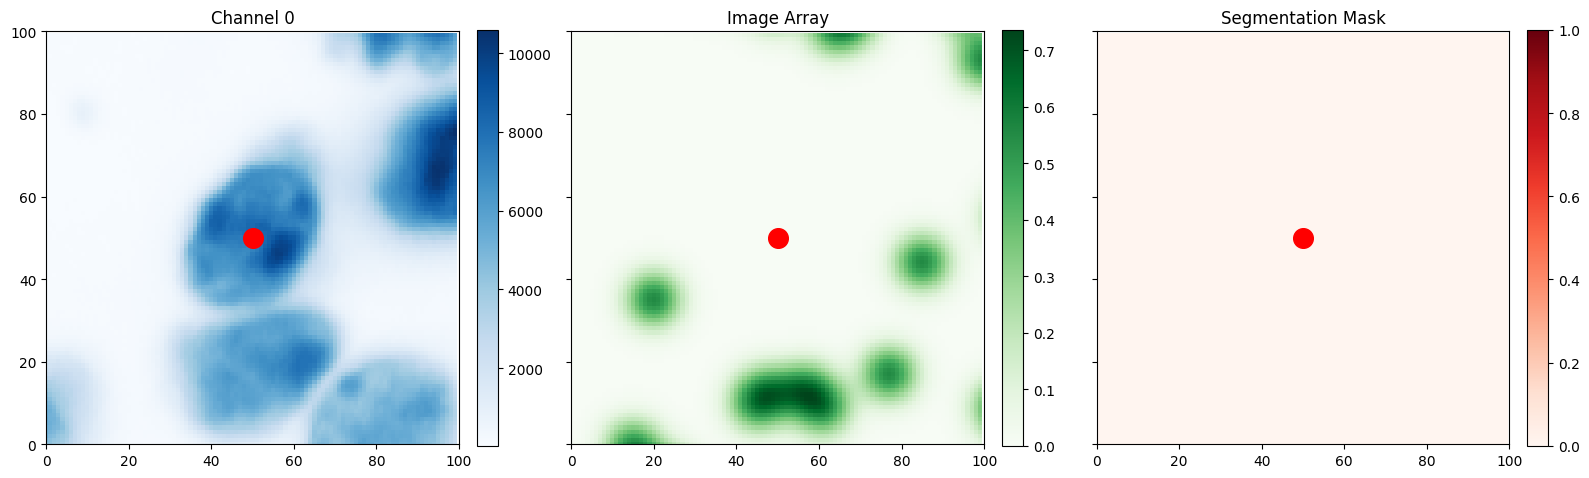

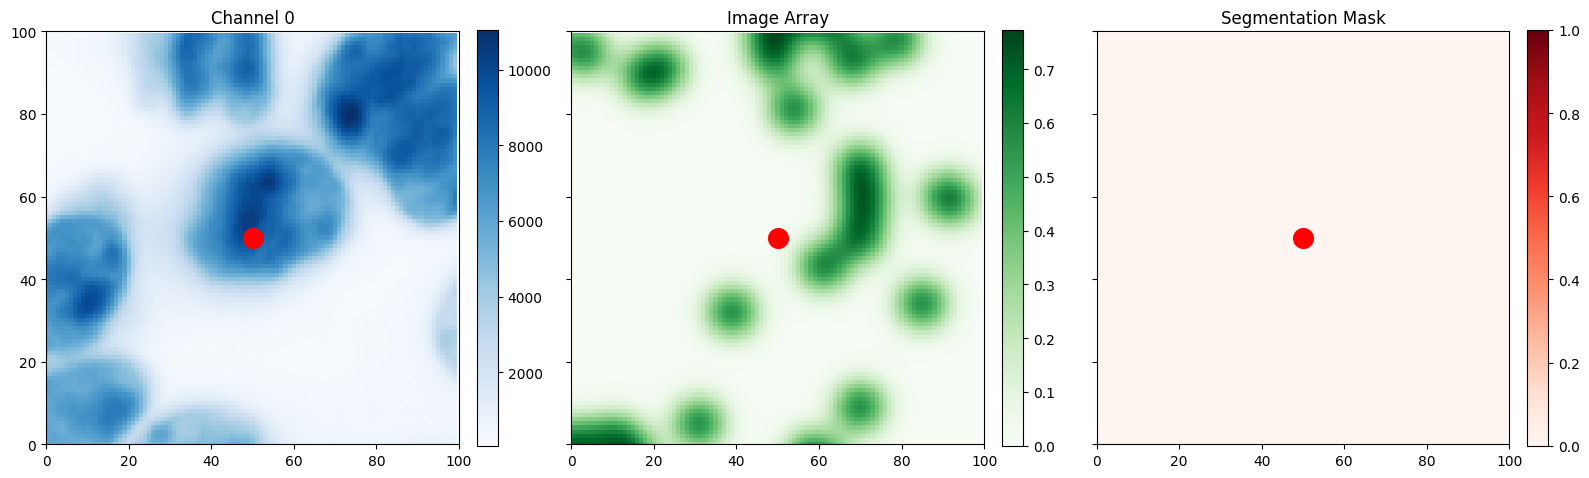

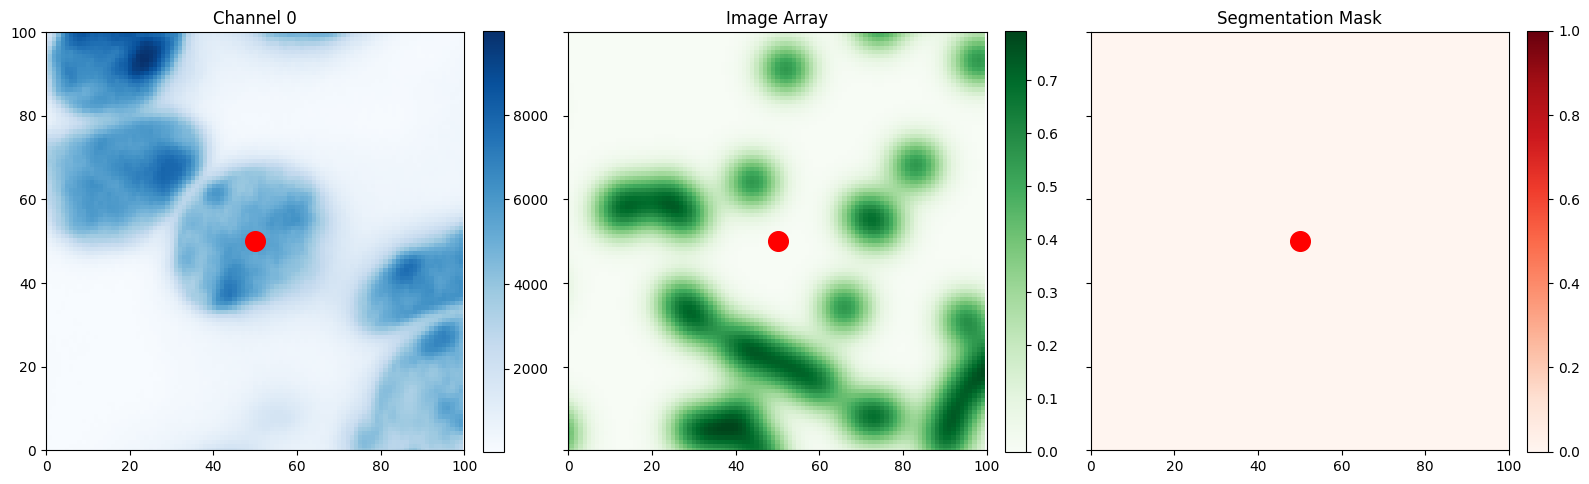

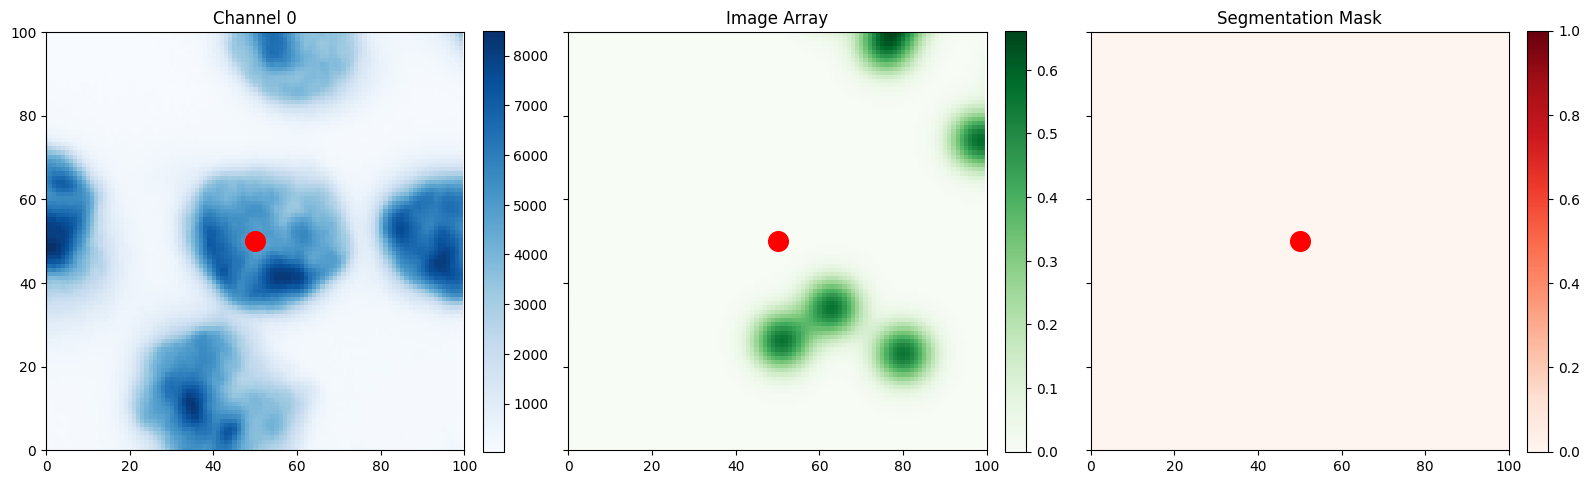

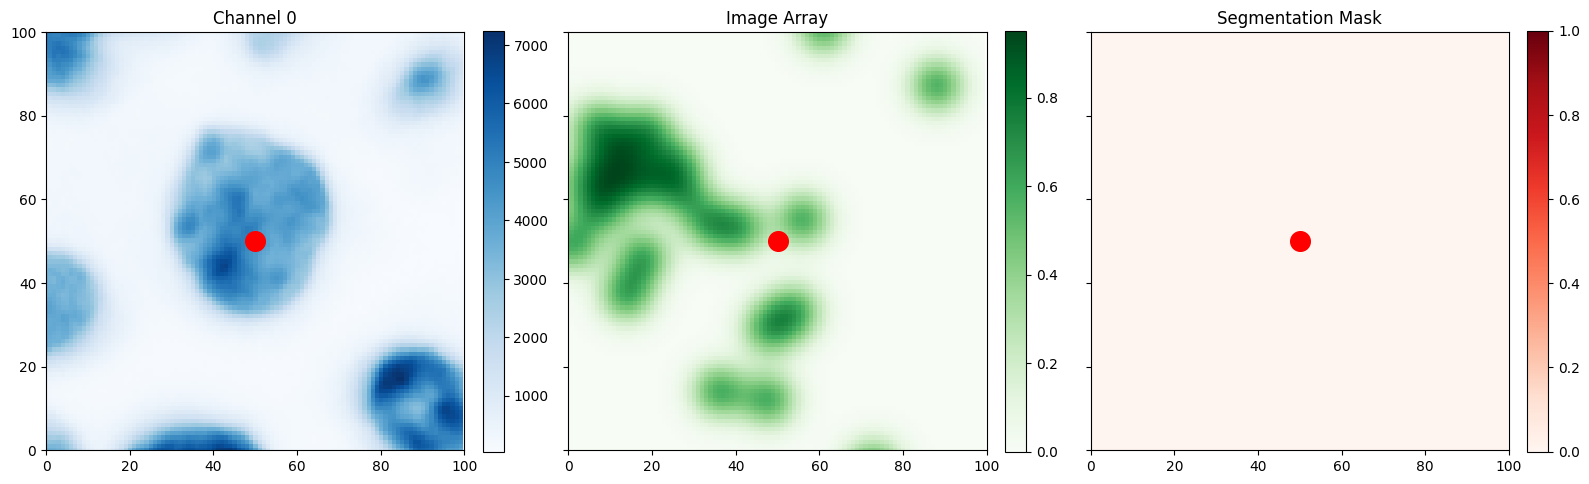

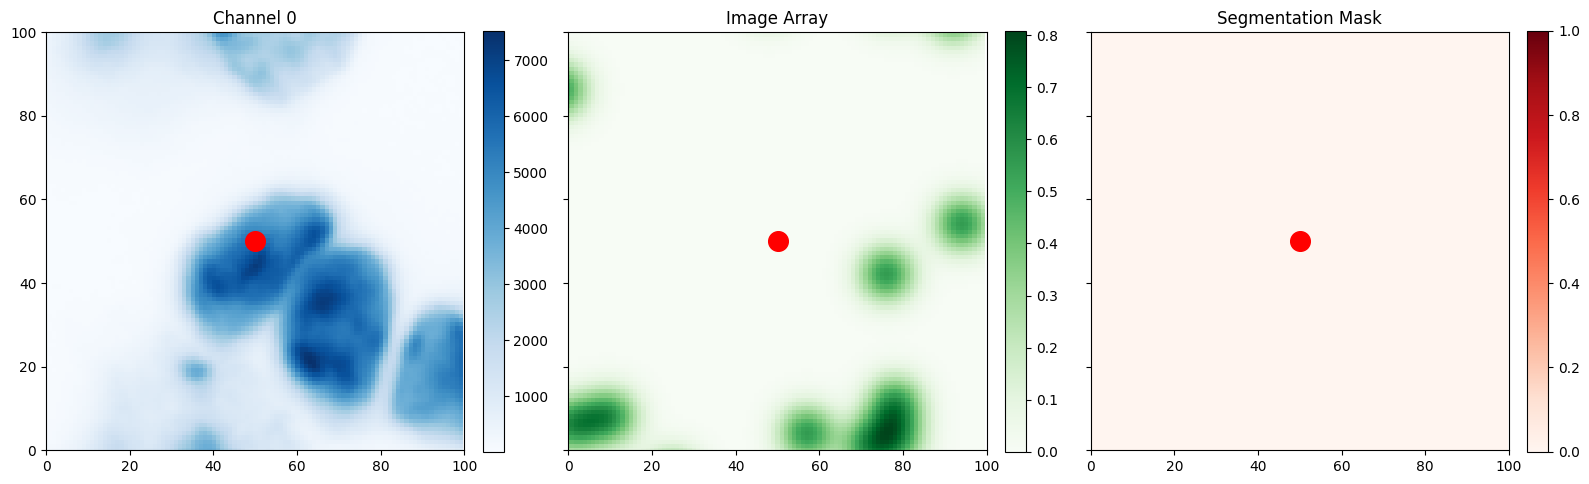

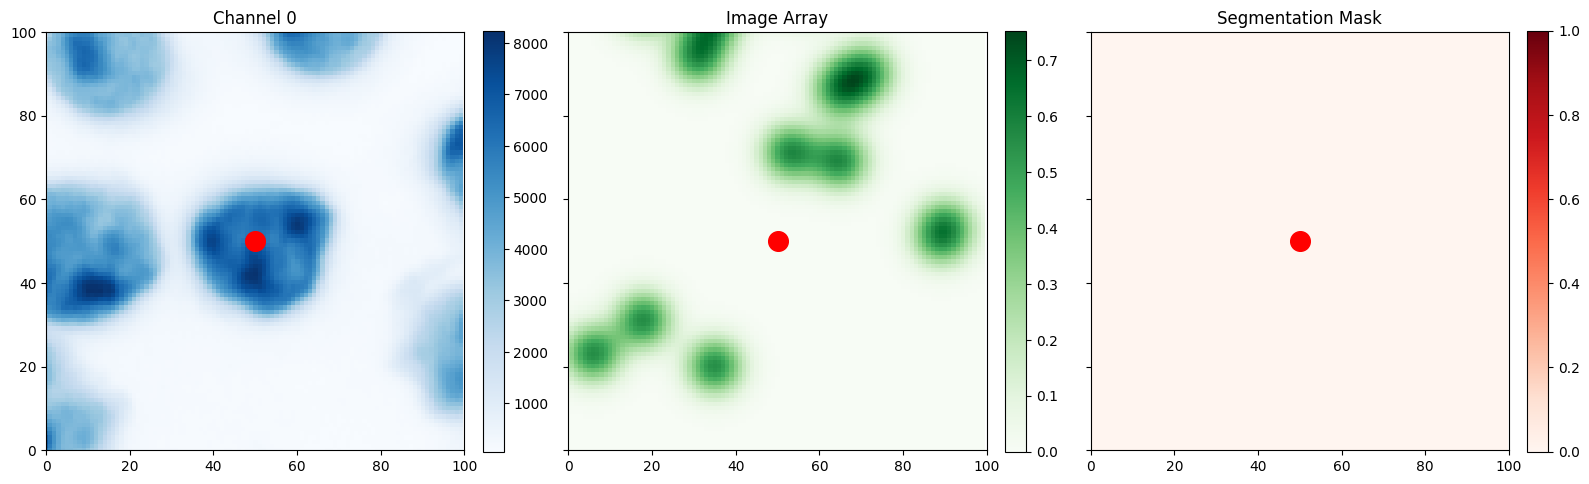

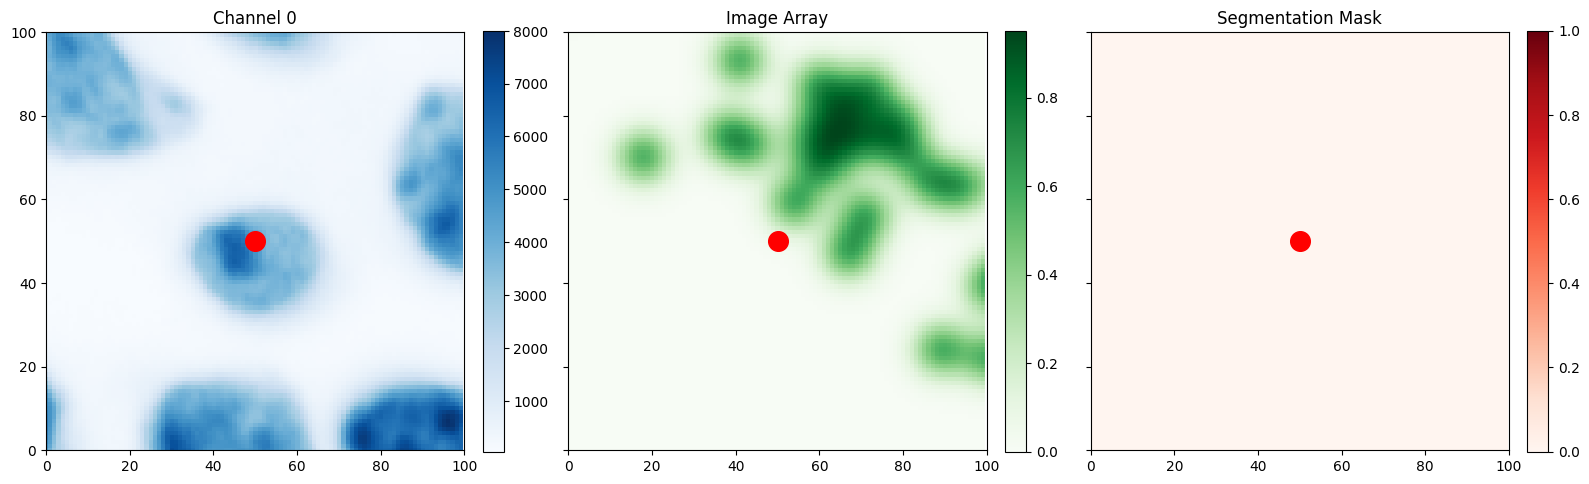

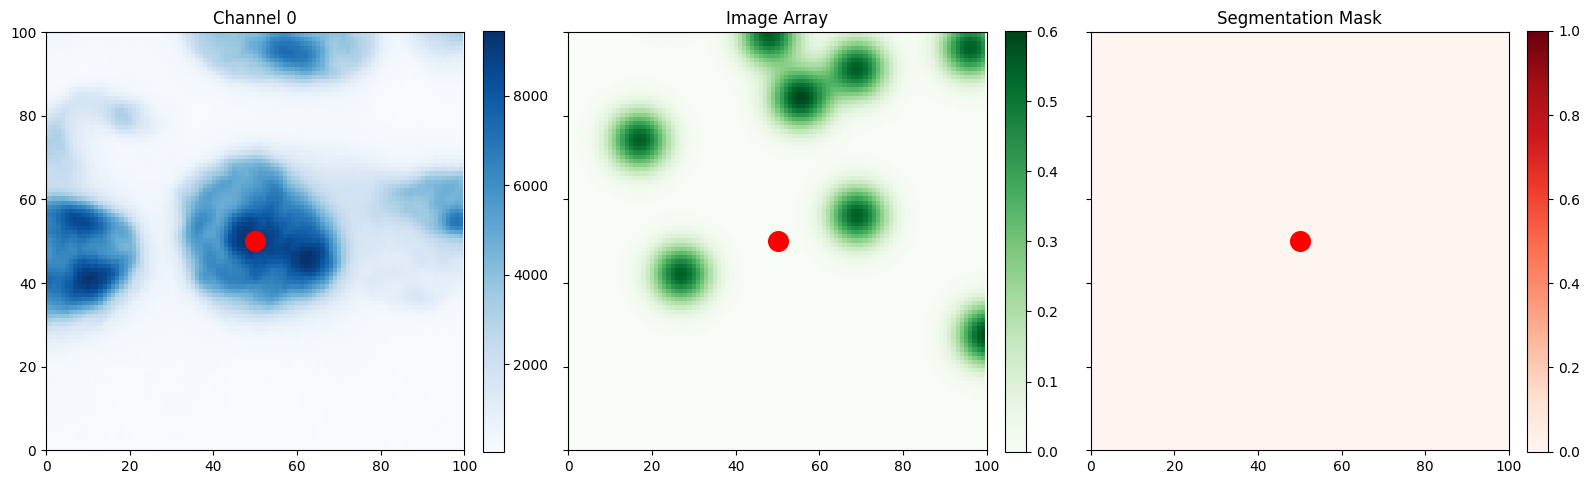

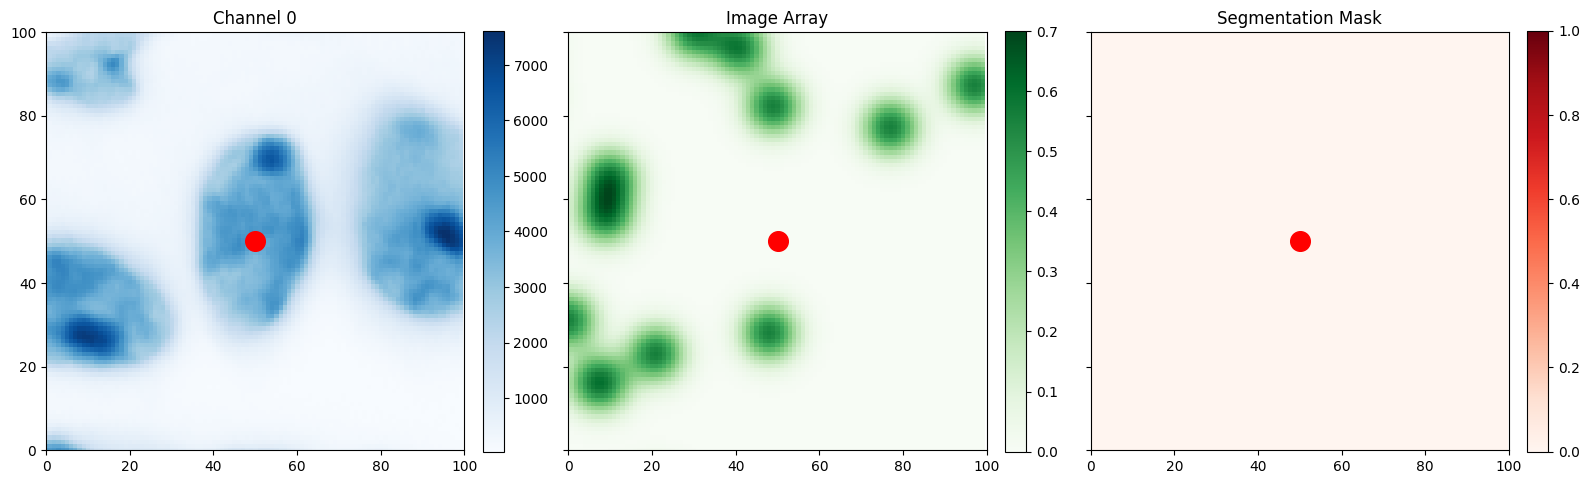

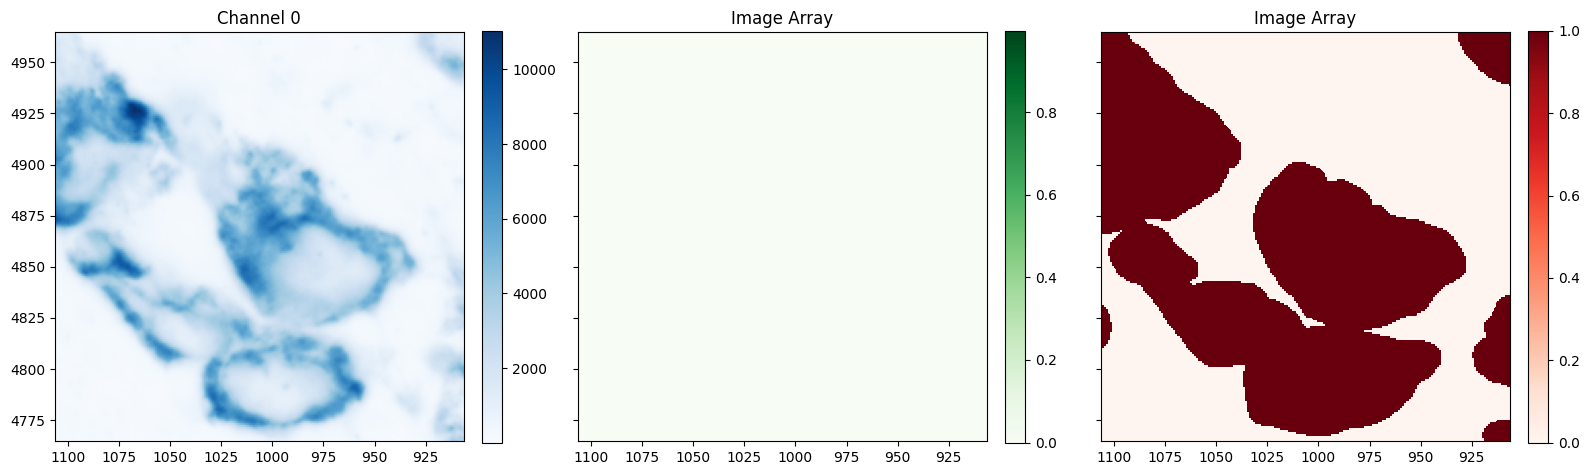

In [ ]:
import matplotlib.pyplot as plt

# Shared axis limits
#xlim = [500, 1000]
#ylim = [2000, 1400]  # Inverted y-axis to match image convention

fig, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)

# First image
im0 = axes[0].imshow(ch0, cmap='Blues')
axes[0].set_title("Channel 0")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Second image
im1 = axes[1].imshow(blurred , cmap='Greens')
axes[1].set_title("Image Array")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# third image

im1 = axes[2].imshow(ch_segmask , cmap='Reds',vmax=1)
axes[2].set_title("Image Array")
plt.colorbar(im1, ax=axes[2], fraction=0.046, pad=0.04)

# Set axis limits identically
for ax in axes:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

plt.tight_layout()
plt.show()


In [ ]:
sdata*binsize_param

SpatialData object, with associated Zarr store: /media/sergio/Meninges/troutpy/xenium_msbrain/mousebrain_prime_crop_communication.zarr
├── Images
│     └── 'morphology_focus': DataTree[cyx] (5, 3000, 5000), (5, 1500, 2500), (5, 750, 1250), (5, 375, 625), (5, 188, 312)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (3000, 5000), (1500, 2500), (750, 1250), (375, 625), (188, 312)
│     └── 'nucleus_labels': DataTree[yx] (3000, 5000), (1500, 2500), (750, 1250), (375, 625), (188, 312)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 17) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (1762, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (1722, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (1750, 1) (2D shapes)
└── Tables
      ├── 'segmentation_free_table': AnnData (2114819, 13035)
      ├── 'source_score': AnnData (834299, 10)
      ├── 'table': AnnData (1703, 4226)
      ├── 'target_score': AnnData (834299, 

(1400.0, 2000.0)

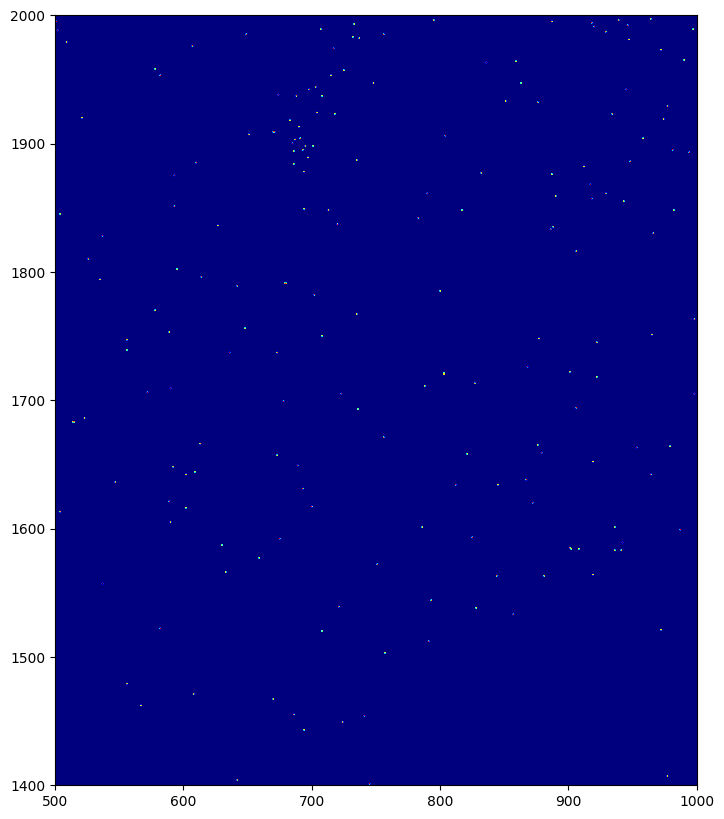

In [ ]:

# the following lines we do to make sure that xy match in both datasets


xalls = []
for f in tqdm(transcripts_all["x"]):
    xalls.append(np.round(f, 4))
yalls = []
for f in tqdm(transcripts_all["y"]):
    yalls.append(np.round(f, 4))
###
transcripts_all["x"] = xalls
transcripts_all["y"] = yalls
transcripts_all["xy"] = transcripts_all["x"].astype(str) + "_" + transcripts_all["y"].astype(str)
transcript2bin_info["xy"] = transcript2bin_info["x"].astype(str) + "_" + transcript2bin_info["y"].astype(str)
id2overlap = dict(zip(transcripts_all["xy"], transcripts_all["overlaps_nucleus"], strict=False))
id2overlap_cell = dict(zip(transcripts_all["xy"], transcripts_all["overlaps_cell"], strict=False))
transcript2bin_info["overlaps_nucleus"] = transcript2bin_info["xy"].map(id2overlap)
transcript2bin_info["overlaps_cell"] = transcript2bin_info["xy"].map(id2overlap_cell)


xalls = []
for f in tqdm(transcripts_all["x"]):
    xalls.append(np.round(f, 4))
yalls = []
for f in tqdm(transcripts_all["y"]):
    yalls.append(np.round(f, 4))
###
transcripts_all["x"] = xalls
transcripts_all["y"] = yalls
transcripts_all["xy"] = transcripts_all["x"].astype(str) + "_" + transcripts_all["y"].astype(str)
transcript2bin_info["xy"] = transcript2bin_info["x"].astype(str) + "_" + transcript2bin_info["y"].astype(str)
id2overlap = dict(zip(transcripts_all["xy"], transcripts_all["overlaps_nucleus"], strict=False))
id2overlap_cell = dict(zip(transcripts_all["xy"], transcripts_all["overlaps_cell"], strict=False))
transcript2bin_info["overlaps_nucleus"] = transcript2bin_info["xy"].map(id2overlap)
transcript2bin_info["overlaps_cell"] = transcript2bin_info["xy"].map(id2overlap_cell)

Before we start it is good to get a brief overview of the two main Classes in sainsc.

- GridCounts: This class holds the data as a dictionary of sparse matrices of the same shape. You rarely will need to interact with it directly unless you want to, filter the genes or crop/mask the sample. It mostly behaves like a Python dictionary but is implemented in Rust. Therefore, iterating over the count matrices of each gene might be slow as the data needs to be transformed every time.
- LazyKDE: This is the class that you mostly will interact with. It contains a GridCounts instance in its counts attribute and otherwise exposes almost all methods necessary to perform the analysis.
We will use the transcripts.csv.gz (or transcripts.parquet) to load the locations of all identified transcripts. The control probes from the Xenium study will be automatically filtered out.

We can furthermore specify the size of the bins we will asign the transcripts into (by default this is set to 0.5 um) and the number of threads we want to use to process the data.

There are options to directly load data from common file formats/technologies such as Stereo-seq, Xenium, and Vizgen. If none of the options fit for your use case you can have a look at LazyKDE.from_dataframe or GridCounts.from_dataframe methods.

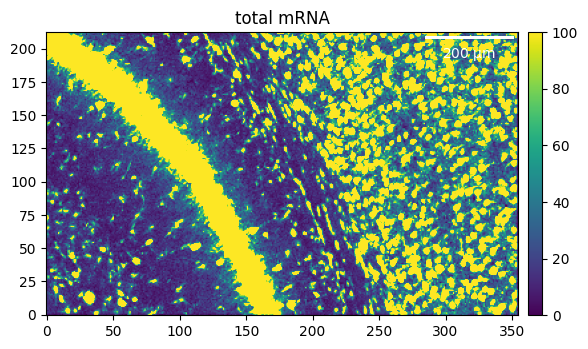

In [ ]:
brain.calculate_total_mRNA()
_ = brain.plot_genecount(im_kwargs={"vmax": 100})
_ = brain.plot_genecount_histogram()

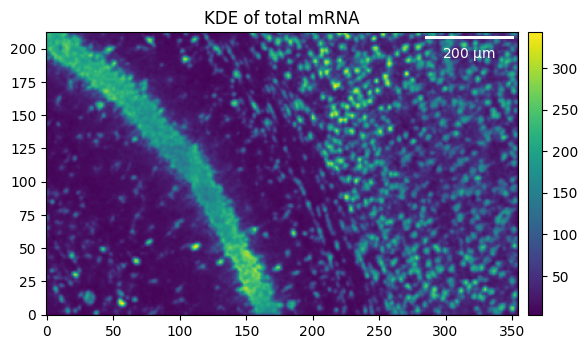

In [ ]:
brain.gaussian_kernel(2.5, unit="um")
brain.calculate_total_mRNA_KDE()
_ = brain.plot_KDE()

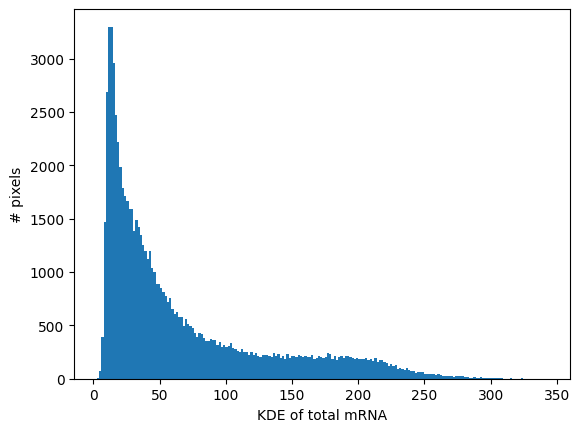

In [ ]:
_ = brain.plot_KDE_histogram(bins=200)

In [ ]:
brain.filter_background(background_filter)

In [ ]:
adata = sdata["table"]
expr = adata.to_df()
expr["cell type"] = adata.obs[celltype_key]
signatures = expr.groupby("cell type").mean().transpose()

In [ ]:
brain.assign_celltype(signatures, log=True)

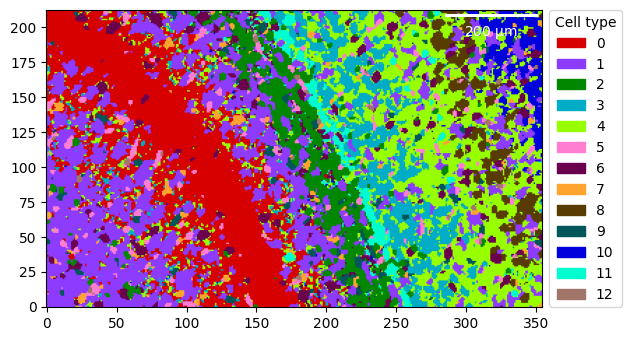

In [ ]:
cmap = dict(zip(brain.celltypes, sns.color_palette(cc.glasbey, n_colors=len(brain.celltypes)), strict=False))

_ = brain.plot_celltype_map(cmap=cmap)

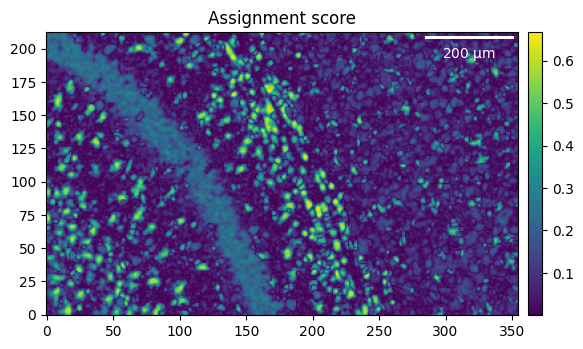

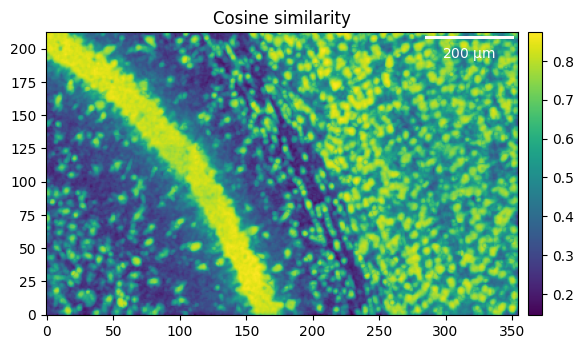

In [ ]:
_ = brain.plot_assignment_score(remove_background=True)
_ = brain.plot_cosine_similarity()

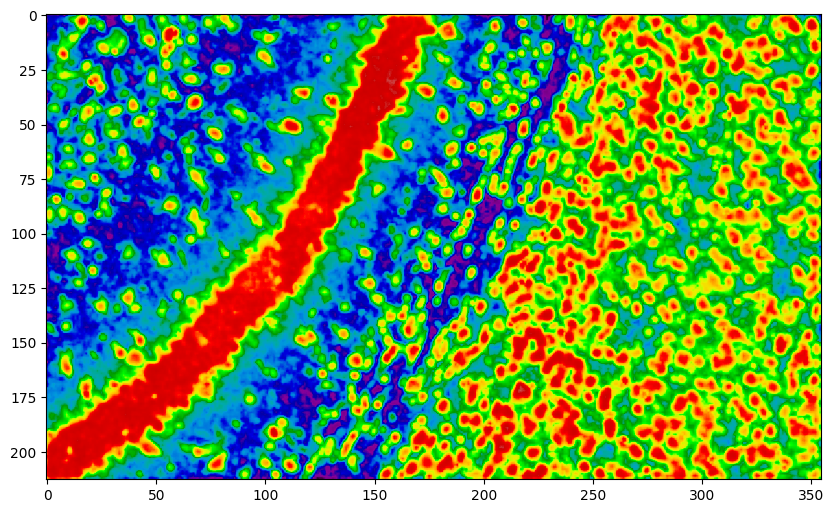

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(brain.cosine_similarity.transpose(), cmap="nipy_spectral", vmax=0.9)

In [ ]:
# Flattened features
celltype = brain.celltype_map.flatten()
assignment_score = brain.assignment_score.flatten()
cosine_similarity = brain.cosine_similarity.flatten()

# Calculate x, y coordinates based on the matrix shape
n_rows, n_cols = brain.celltype_map.shape  # Assuming brain.shape gives the shape of the matrix
x_coordinates, y_coordinates = np.meshgrid(np.arange(n_cols), np.arange(n_rows))

# Flatten the x and y coordinates to match the flattened data
x_coordinates = x_coordinates.flatten()
y_coordinates = y_coordinates.flatten()

# Create the DataFrame with the extracted features and coordinates
output_df = pd.DataFrame(
    {
        "bin_x": x_coordinates,
        "bin_y": y_coordinates,
        "cell type": celltype,
        "assignment_score": assignment_score,
        "cosine_similarity": cosine_similarity,
    }
)

# Map the cell type numbers to their actual names
num2ct = dict(zip(range(0, len(brain.celltypes)), brain.celltypes, strict=False))
output_df["cell type"] = output_df["cell type"].map(num2ct)

output_df["bin_x_y_id"] = output_df["bin_y"].astype(str) + "_" + output_df["bin_x"].astype(str)

# View the final DataFrame
output_df.head()

bin_x  bin_y cell type  assignment_score  cosine_similarity bin_x_y_id
0      0      0         1          0.112851           0.245814        0_0
1      1      0         1          0.083987           0.249253        0_1
2      2      0         1          0.031190           0.233372        0_2
3      3      0         1          0.054114           0.234161        0_3
4      4      0         1          0.074469           0.256074        0_4

In [ ]:
bin2celltype = dict(zip(output_df["bin_x_y_id"], output_df["cell type"], strict=False))
bin2cosine_similarity = dict(zip(output_df["bin_x_y_id"], output_df["cosine_similarity"], strict=False))
bin2assignment_score = dict(zip(output_df["bin_x_y_id"], output_df["assignment_score"], strict=False))
transcript2bin_info["closest_cell_type"] = transcript2bin_info["bin_x_y_id"].map(bin2celltype)
transcript2bin_info["cosine_similarity"] = transcript2bin_info["bin_x_y_id"].map(bin2cosine_similarity)

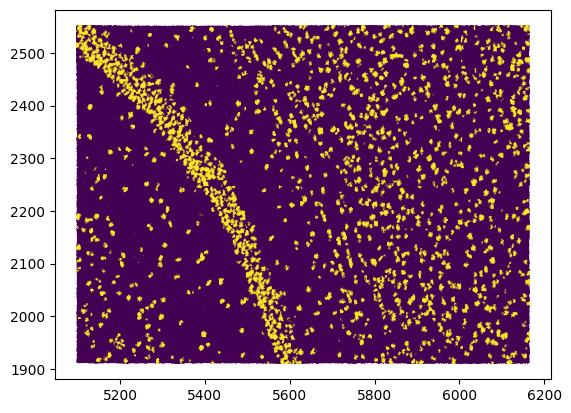

In [ ]:
plt.scatter(transcript2bin_info["x"], transcript2bin_info["y"], c=transcript2bin_info["overlaps_nucleus"], s=0.1)
plt.figure()
plt.scatter(transcript2bin_info["x"], transcript2bin_info["y"], c=transcript2bin_info["cosine_similarity"], s=0.1)

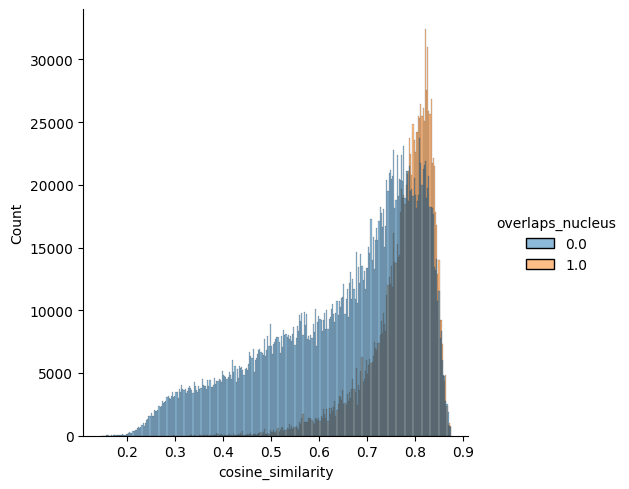

In [ ]:
sns.displot(transcript2bin_info, x="cosine_similarity", hue="overlaps_nucleus")

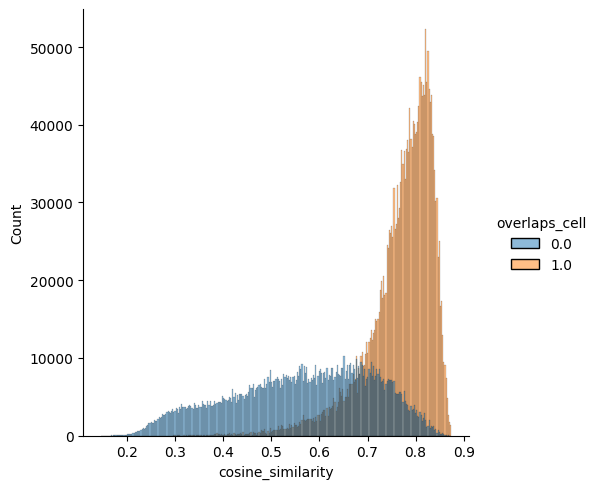

In [ ]:
sns.displot(transcript2bin_info, x="cosine_similarity", hue="overlaps_cell")

In [ ]:
# we should make the overlaps_cell column flexible, depending on the key specified. We also should make the percentile dependent on the given input
threshold = np.percentile(transcript2bin_info.loc[transcript2bin_info["overlaps_cell"] == 1, "cosine_similarity"], 10)
transcript2bin_info["match_cell_signature"] = transcript2bin_info["cosine_similarity"] > threshold
print(threshold)

0.6785410046577454


In [ ]:
xy2cosine_similarity = dict(zip(transcript2bin_info["xy"], transcript2bin_info["cosine_similarity"], strict=False))
xy2closest_cell_type = dict(zip(transcript2bin_info["xy"], transcript2bin_info["closest_cell_type"], strict=False))
transcripts_all["cosine_similarity"] = transcripts_all["xy"].map(xy2cosine_similarity)
transcripts_all["closest_cell_type"] = transcripts_all["xy"].map(xy2closest_cell_type)
id2cosine = dict(zip(transcripts_all.index, transcripts_all["cosine_similarity"], strict=False))
id2ct = dict(zip(transcripts_all.index, transcripts_all["closest_cell_type"], strict=False))
transi = sdata.points["transcripts"].compute()
transi["cosine_similarity"] = transi.index.map(id2cosine)
transi["closest_cell_type"] = transi.index.map(id2ct)
transi["match_cell_signature"] = transi["cosine_similarity"] > threshold

# now we reformat transcripts as points.

### plot cosine similarity by cell type

In [ ]:
for g, i in transcript2bin_info.groupby("closest_cell_type"):
    sns.displot(i, x="cosine_similarity", hue="overlaps_cell")
    plt.title(g)
    plt.show()

# Function implementation [TO BE ADDED TO PACKAGE]

In [ ]:
troutpy.pp.segmentation_free_sainsc(sdata, binsize=3, celltype_key="leiden", background_filter=0.4, gaussian_kernel_key=2.5, n_threads=16)

In [ ]:
troutpy.pp.define_extracellular(sdata, layer="transcripts", method="sainsc", unassigned_tag="UNASSIGNED", copy=False, percentile_threshold=2)

Cosine similarity threshold for extracellular definition: 0.5665629506111145


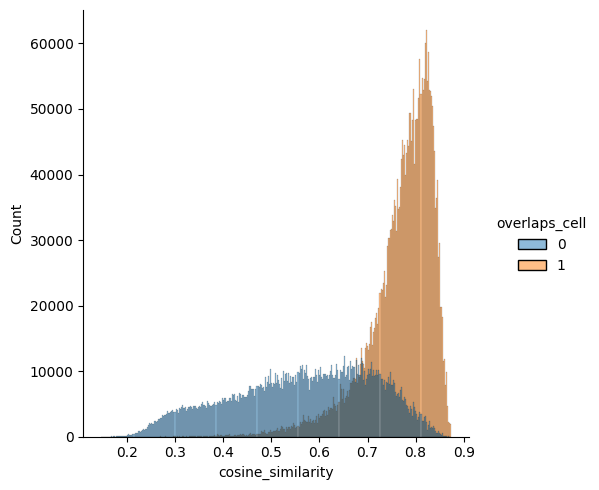

In [ ]:
transcript = sdata["transcripts"].compute()
sns.displot(transcript, x="cosine_similarity", hue="overlaps_cell")

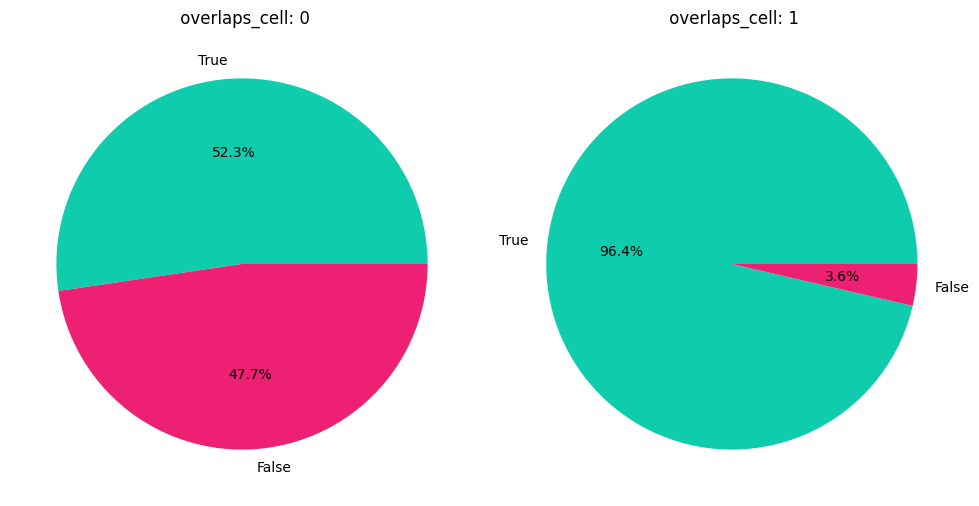

In [ ]:
troutpy.pl.pie(sdata, groupby="match_cell_signature", group_key="overlaps_cell")

<Figure size 500x500 with 0 Axes>

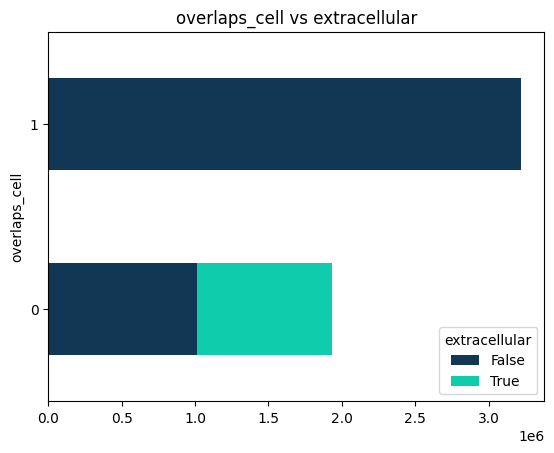

In [ ]:
troutpy.pl.crosstab(sdata, yvar="extracellular", xvar="overlaps_cell", normalize=False, cmap="troutpy", kind="barh", stacked=True)

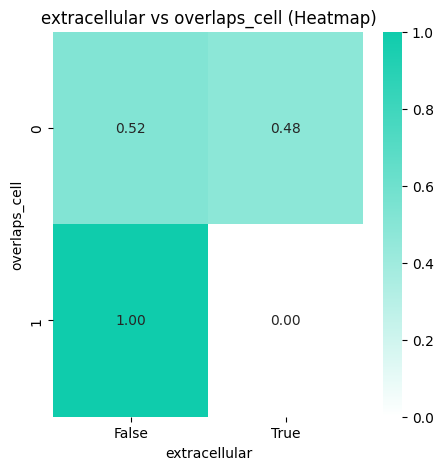

In [ ]:
troutpy.pl.crosstab(sdata, xvar="extracellular", yvar="overlaps_cell", normalize=True, cmap="Aquas", kind="heatmap", stacked=True)

In [ ]:
fraction = 0.1  # 10% of transcripts
subsampled_transcripts = transcript.sample(frac=fraction, random_state=42)
subsampled_transcripts.to_csv("/media/sergio/Meninges/troutpy/trans.csv")

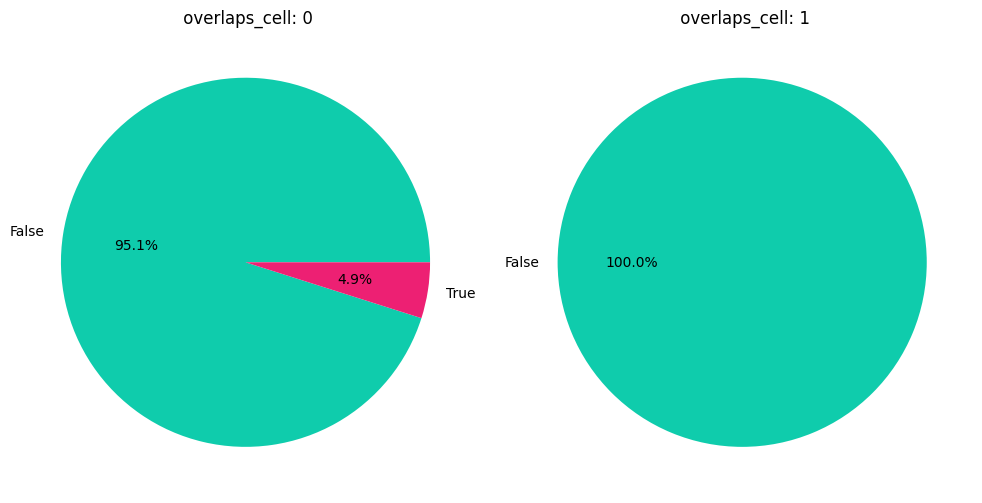

In [ ]:
troutpy.pl.pie(sdata, groupby="extracellular", group_key="overlaps_cell")